In [11]:
#Upload libraries
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(RColorBrewer)
library(ggrepel)

In [4]:
#Upload data
host_data_comm_sia <- read_delim("genomes_download/plots_data/accession_complete_fields.tsv", 
                                 delim = "\t", escape_double = FALSE, 
                                 trim_ws = TRUE)
head(host_data_comm_sia)
colnames(host_data_comm_sia)

Rows: 2459 Columns: 11
── Column specification ──────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): Assembly Accession, Assembly BioSample Geographic location, Assembl...
dbl (4): Assembly Stats GC Percent, Assembly Stats Total Sequence Length, Or...
lgl (1): Organelle Assembly Name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Assembly Accession,Assembly BioSample Geographic location,Assembly BioSample Host,Assembly BioSample Host disease,Assembly BioSample Isolation source,Assembly Stats GC Percent,Assembly Stats Total Sequence Length,Organelle Assembly Name,Organism Name,Organism Taxonomic ID,Annotation Count Gene Protein-coding
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>
GCF_000007985.2,NA,NA,NA,NA,61.0,3814128,NA,Geobacter sulfurreducens PCA,243231,3405
GCF_000009085.1,NA,NA,NA,NA,30.5,1641481,NA,Campylobacter jejuni subsp. jejuni NCTC 11168 = ATCC 700819,192222,1572
GCF_000009465.1,NA,NA,NA,NA,51.5,2194961,NA,Neisseria meningitidis FAM18,272831,1971
GCF_000012185.1,NA,NA,NA,NA,38.0,1914490,NA,Haemophilus influenzae 86-028NP,281310,1785
GCF_000014105.1,NA,NA,NA,NA,51.5,2153416,NA,Neisseria meningitidis 053442,374833,1909
GCF_000019305.1,NA,NA,NA,NA,28.0,4107013,NA,Clostridium botulinum B1 str. Okra,498213,3741


[1] "Assembly Accession"                    
 [2] "Assembly BioSample Geographic location"
 [3] "Assembly BioSample Host"               
 [4] "Assembly BioSample Host disease"       
 [5] "Assembly BioSample Isolation source"   
 [6] "Assembly Stats GC Percent"             
 [7] "Assembly Stats Total Sequence Length"  
 [8] "Organelle Assembly Name"               
 [9] "Organism Name"                         
[10] "Organism Taxonomic ID"                 
[11] "Annotation Count Gene Protein-coding"

In [5]:
#select columms
host_data_comm_sia <- host_data_comm_sia%>%select(`Assembly BioSample Host`)

# Filter multiple names attributed to a single organism

In [14]:
#filtering swine data
host_data_comm_sia <- host_data_comm_sia %>%
  mutate(`Assembly BioSample Host` = if_else(
    str_detect(`Assembly BioSample Host`, fixed("pig", ignore_case = TRUE)) |
      str_detect(`Assembly BioSample Host`, fixed("swine", ignore_case = TRUE)) |
      str_detect(`Assembly BioSample Host`, fixed("Porcine", ignore_case = TRUE)) |
      str_detect(`Assembly BioSample Host`, fixed("Pork", ignore_case = TRUE)) |
      str_detect(`Assembly BioSample Host`, fixed("Sus scrofa", ignore_case = TRUE)),
    "Swine",
    `Assembly BioSample Host`
  ))

#filtering bovine data
host_data_comm_sia <- host_data_comm_sia %>%
  mutate(`Assembly BioSample Host` = case_when(
    str_detect(`Assembly BioSample Host`, regex("Bos taurus|Cattle|cow|Cow|Dairy Cow|Ox|bovine|Dairy cows", ignore_case = TRUE)) ~ "Bovine",
    TRUE ~ `Assembly BioSample Host`
  ))


#filtering human data
host_data_comm_sia <- host_data_comm_sia %>%
  mutate(`Assembly BioSample Host` = case_when(
    str_detect(`Assembly BioSample Host`, regex("Homo sapiens|Human infant|Human male|Human female|'Human (Female)'", ignore_case = TRUE)) ~ "Homo sapiens",
    TRUE ~ `Assembly BioSample Host`
  ))

#filtering horse data
host_data_comm_sia <- host_data_comm_sia %>%
  mutate(`Assembly BioSample Host` = case_when(
    str_detect(`Assembly BioSample Host`, regex("horse|Horse (Foal)", ignore_case = TRUE)) ~ "horse",
    TRUE ~ `Assembly BioSample Host`
  ))


#filtering chicken data
host_data_comm_sia <- host_data_comm_sia %>%
  mutate(`Assembly BioSample Host` = case_when(
    str_detect(`Assembly BioSample Host`, regex("chicken|Gallus gallus domesticus|Gallus|Avian|avian|duck|turkey|Poultry|Duck| White Stork|goose|poultry",
                                                ignore_case = TRUE)) ~ "Aves",
    TRUE ~ `Assembly BioSample Host`
  ))



# Filter NA and Unkown information attributed. Then, count as "not available"

In [15]:
#filter NA and unkown for counting
host_data_comm_sia <- host_data_comm_sia %>% 
  mutate(`Assembly BioSample Host` = if_else(
    is.na(`Assembly BioSample Host`) |
      str_detect(str_to_lower(`Assembly BioSample Host`),
                 regex("^(na|n/a|n|missing|not available|not applicable|not collected|-|unknown|not avaialable: not collected|None)$")),
    "Não disponível",
    `Assembly BioSample Host`
  ))


# Make data for chart

In [16]:
#make data for chart

host_data_comm_sia_1 <- host_data_comm_sia %>%
  group_by(`Assembly BioSample Host`) %>%             # Group by 'region'
  mutate(host_count = n()) %>%   # Count occurrences and add to new column
  ungroup()                        # Remove grouping



host_final <- host_data_comm_sia_1%>%select(`Assembly BioSample Host`, 'host_count')


host_final_unique <- host_final %>%
  distinct(`Assembly BioSample Host`, .keep_all = TRUE)

head(host_final_unique)

host_final_unique <- host_final_unique %>%
  mutate(perc_host = host_count / sum(host_count) * 100) %>%
 filter(perc_host >= 0.5 )  

host_final_unique <- host_final_unique %>%
  add_row(
    'Assembly BioSample Host' = "Outros",
    host_count = 200,
    perc_host = 10.66
  )

perc_host_round <-round(host_final_unique$perc_host, digits = 2)

Assembly BioSample Host,host_count
<chr>,<int>
Não disponível,1249
Swine,72
sheep,1
Homo sapiens,572
Bovine,198
Melopsittacus undulatus,1


In [17]:
# Create and change color pallete
custom_colors <- brewer.pal(n = 8, name = "PuRd")
custom_colors[1] <- "#007C77"
custom_colors[2] <- "#00B295" 
custom_colors[3] <- "#92BFB1"
custom_colors[4] <- "#16E0BD"
custom_colors[5] <- "#00E5E8"
custom_colors[6] <- "#C5FFFD"
custom_colors[7] <- "#C9DAEA" # Substitui o tom mais escuro por um tom claro
custom_colors[8] <- "#DFE0E2"

In [18]:
View(host_final_unique)

Assembly BioSample Host,host_count,perc_host
<chr>,<dbl>,<dbl>
Não disponível,1249,50.7930053
Swine,72,2.9280195
Homo sapiens,572,23.2614884
Bovine,198,8.0520537
Aves,91,3.7006913
horse,21,0.8540057
rabbit,18,0.7320049
Outros,200,10.6600000


# Create chart 

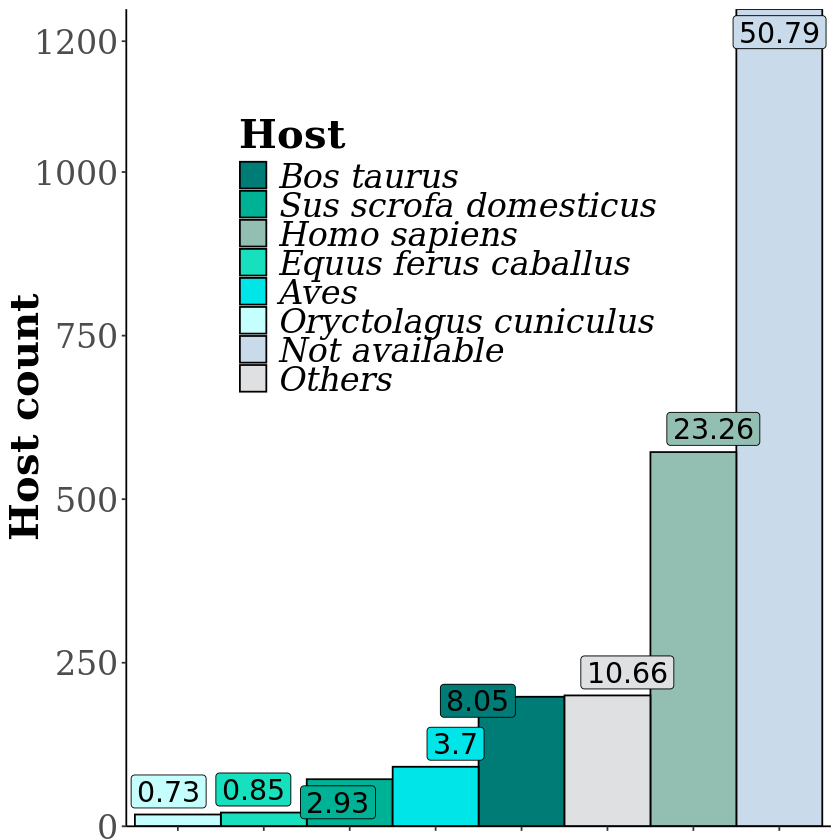

In [19]:
host_graph <-ggplot(host_final_unique, aes(x = reorder(`Assembly BioSample Host`,host_count), y = host_count, fill = `Assembly BioSample Host`)) +
  geom_bar(stat = "identity", width = 1, color = "black") +
  theme_classic() +
  theme(plot.title = element_blank(),
        legend.text=element_text(size=20, family = "Times", face = "italic"),
        legend.title=element_text(size=24, face= "bold", family = "Times"),
        axis.text.x =  element_blank(),
        axis.text.y = element_text(size = 20, family = "Times"),
        axis.title.y = element_text(size = 24, family = "Times", face = "bold"),
        axis.title.x =  element_blank(),
        legend.position = c(0.4,0.7)) +
  labs(fill = "Host", y = "Host count") +
  geom_label_repel(aes(label = perc_host_round),
                   color = "black",
                   show.legend = FALSE,
                   box.padding = 0.2,
                   size = 6) +
  scale_fill_manual(
    values = custom_colors,
    labels = c("Homo sapiens" = "Homo sapiens", "horse" = "Equus ferus caballus", "Aves" = "Aves", "rabbit"= "Oryctolagus cuniculus",
               "Swine" = "Sus scrofa domesticus", "Bovine" = "Bos taurus","Não disponível" = "Not available", "Outros" = "Others"),
    breaks = c("Bovine", "Swine","Homo sapiens", "horse", "Aves", "rabbit", "Não disponível", "Outros")
  ) + scale_y_continuous(expand = expansion(), breaks = c(0,250,500,750,1000,1200))

print(host_graph)